In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]
graph.add_edges(graph.edges()[1], graph.edges()[0])

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_36_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f1a3c0c5900> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(61825)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

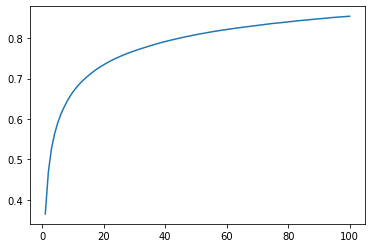

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.3651, 0.4693, 0.5260, 0.5624, 0.5894, 0.6104, 0.6274, 0.6425, 0.6556,
        0.6669, 0.6769, 0.6856, 0.6937, 0.7005, 0.7072, 0.7133, 0.7193, 0.7245,
        0.7294, 0.7340, 0.7385, 0.7427, 0.7466, 0.7501, 0.7536, 0.7569, 0.7600,
        0.7631, 0.7657, 0.7684, 0.7712, 0.7736, 0.7760, 0.7783, 0.7809, 0.7830,
        0.7853, 0.7875, 0.7896, 0.7915, 0.7934, 0.7953, 0.7971, 0.7988, 0.8005,
        0.8022, 0.8039, 0.8053, 0.8070, 0.8085, 0.8100, 0.8114, 0.8125, 0.8140,
        0.8153, 0.8167, 0.8178, 0.8191, 0.8202, 0.8213, 0.8225, 0.8236, 0.8247,
        0.8256, 0.8266, 0.8276, 0.8285, 0.8296, 0.8305, 0.8315, 0.8324, 0.8334,
        0.8344, 0.8354, 0.8363, 0.8370, 0.8378, 0.8386, 0.8394, 0.8402, 0.8411,
        0.8419, 0.8427, 0.8435, 0.8443, 0.8449, 0.8457, 0.8464, 0.8471, 0.8478,
        0.8484, 0.8492, 0.8499, 0.8507, 0.8513, 0.8519, 0.8525, 0.8530, 0.8536,
        0.8541])

In [18]:
percentages.max()

tensor(0.8541)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.65014202, 0.63237925, 0.62102557, 0.61239319, 0.60555205,
       0.59991654, 0.59509989, 0.59097734, 0.58725519, 0.58399461,
       0.58107671, 0.5782977 , 0.57584765, 0.57353208, 0.57147683,
       0.56950834, 0.56770856, 0.56596933, 0.56428544, 0.56274986,
       0.5612728 , 0.55984197, 0.55850886, 0.55726863, 0.55605865,
       0.55494356, 0.553826  , 0.55276759, 0.55168443, 0.5507101 ,
       0.54976719, 0.54883801, 0.54792219, 0.54706546, 0.5462209 ,
       0.54547198, 0.5447064 , 0.54393978, 0.54320763, 0.54246057,
       0.54172301, 0.54103422, 0.54031991, 0.53967043, 0.53903471,
       0.53843935, 0.53784218, 0.53724098, 0.5366436 , 0.53611451,
       0.53558788, 0.53506561, 0.53455513, 0.53402584, 0.53351428,
       0.53303207, 0.53257351, 0.53211611, 0.53164768, 0.53119222,
       0.53072709, 0.53029774, 0.52984039, 0.52940777, 0.52899482,
       0.52857335, 0.52816649, 0.52778107, 0.52738217, 0.52698471,
       0.52660402, 0.52622595, 0.52584683, 0.52546822, 0.52511

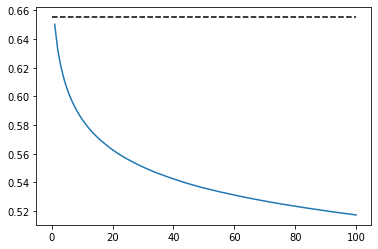

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f1927bbec00> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(70454)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.774569692381192

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  92115,  30038, ..., 136490,  25208,  33955],
       [     1, 154949, 100594, ..., 159273, 124862, 145133],
       [     2, 161752,  99520, ...,  31874, 133004,  96053],
       ...,
       [169340,  18094, 152563, ..., 139390,  38886,  35723],
       [169341, 151378,  76852, ...,  53055,  91333,  95095],
       [169342,  76612,  97498, ...,  46496,  31066, 121872]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.549139384762384

In [40]:
distances

array([[1.        , 0.9883578 , 0.98639107, ..., 0.8683719 , 0.86806613,
        0.8679039 ],
       [0.9999998 , 0.99747354, 0.8788872 , ..., 0.6429393 , 0.64278454,
        0.6427588 ],
       [1.0000001 , 0.9888833 , 0.9885578 , ..., 0.95217013, 0.952151  ,
        0.9519532 ],
       ...,
       [1.0000001 , 0.9529139 , 0.9478477 , ..., 0.83408946, 0.83406013,
        0.8336184 ],
       [1.0000001 , 0.979885  , 0.9782261 , ..., 0.93797445, 0.9379211 ,
        0.9374394 ],
       [1.        , 0.9444553 , 0.9240569 , ..., 0.8181906 , 0.8167215 ,
        0.816415  ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

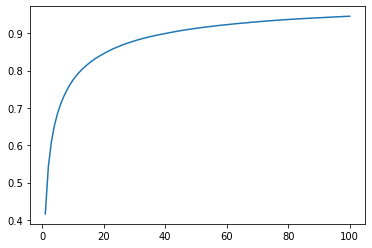

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.4160, 0.5429, 0.6100, 0.6540, 0.6857, 0.7104, 0.7304, 0.7473, 0.7621,
        0.7747, 0.7854, 0.7952, 0.8036, 0.8112, 0.8182, 0.8248, 0.8307, 0.8360,
        0.8409, 0.8454, 0.8499, 0.8541, 0.8583, 0.8616, 0.8649, 0.8685, 0.8714,
        0.8742, 0.8770, 0.8796, 0.8821, 0.8844, 0.8867, 0.8887, 0.8907, 0.8926,
        0.8944, 0.8962, 0.8978, 0.8994, 0.9010, 0.9026, 0.9041, 0.9056, 0.9071,
        0.9083, 0.9096, 0.9109, 0.9121, 0.9132, 0.9144, 0.9155, 0.9165, 0.9175,
        0.9185, 0.9194, 0.9205, 0.9214, 0.9223, 0.9230, 0.9239, 0.9248, 0.9256,
        0.9264, 0.9272, 0.9278, 0.9286, 0.9295, 0.9301, 0.9308, 0.9315, 0.9322,
        0.9329, 0.9335, 0.9341, 0.9347, 0.9353, 0.9359, 0.9365, 0.9370, 0.9374,
        0.9380, 0.9384, 0.9389, 0.9395, 0.9399, 0.9404, 0.9408, 0.9413, 0.9416,
        0.9420, 0.9425, 0.9429, 0.9433, 0.9437, 0.9441, 0.9445, 0.9450, 0.9453,
        0.9457])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.65872814, 0.64340126, 0.63240287, 0.62330891, 0.61687935,
       0.61129876, 0.60655846, 0.60236399, 0.59871713, 0.59542762,
       0.59245329, 0.58976112, 0.58727735, 0.5850206 , 0.58289861,
       0.58094038, 0.57916529, 0.57741651, 0.57583752, 0.57434763,
       0.57282585, 0.57145637, 0.57020957, 0.5689311 , 0.56777712,
       0.56666147, 0.56554711, 0.56447502, 0.56351575, 0.56261611,
       0.56166898, 0.56081795, 0.56000185, 0.55910194, 0.55830845,
       0.55749688, 0.55674242, 0.55604353, 0.55532838, 0.55461017,
       0.55392843, 0.55326482, 0.55263756, 0.55203143, 0.55141603,
       0.55079991, 0.55021516, 0.54963029, 0.54911039, 0.54857951,
       0.54803252, 0.54751008, 0.5470048 , 0.54651276, 0.54603207,
       0.54554851, 0.54507373, 0.54461186, 0.54415775, 0.54372674,
       0.54329572, 0.54287128, 0.54247297, 0.54204678, 0.54164779,
       0.54124389, 0.54085654, 0.54047936, 0.54011124, 0.53970336,
       0.53934872, 0.53900007, 0.53862644, 0.53826968, 0.53792

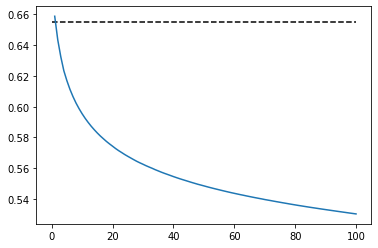

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f1925a366f0> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(72426)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

4.066977181297261

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[  1353,  69794,  67166, ...,  42039, 128644,  21483],
       [141692, 154949, 168455, ...,  47911, 162837, 101322],
       [168209,  87117, 152349, ...,  35226, 148470, 135323],
       ...,
       [143001,  41480, 154342, ...,  70552, 103884,  11752],
       [123288, 140574,  61100, ..., 132903, 164567, 159541],
       [ 27824,  25265,  64718, ...,  84927,  13977, 149856]])

In [61]:
sum(embeddings[0] * embeddings[411])

7.1339543625945225

In [62]:
distances

array([[48.005554 , 46.393955 , 45.95478  , ..., 33.72845  , 33.673084 ,
        33.569923 ],
       [ 4.4882507,  4.41385  ,  4.181525 , ...,  3.1349468,  3.133686 ,
         3.132765 ],
       [ 8.527153 ,  8.337188 ,  8.260342 , ...,  7.232099 ,  7.2320776,
         7.230867 ],
       ...,
       [ 8.974858 ,  8.858664 ,  8.68024  , ...,  6.945816 ,  6.9347463,
         6.9263144],
       [ 9.864608 ,  9.71272  ,  9.696562 , ...,  7.125076 ,  7.121863 ,
         7.1193595],
       [ 7.0395207,  6.796824 ,  6.6201367, ...,  4.2446446,  4.205452 ,
         4.199805 ]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.]])

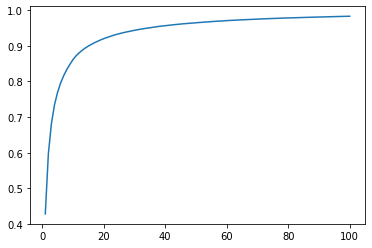

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.4277, 0.5969, 0.6821, 0.7344, 0.7694, 0.7958, 0.8163, 0.8336, 0.8478,
        0.8611, 0.8718, 0.8801, 0.8874, 0.8937, 0.8992, 0.9040, 0.9086, 0.9126,
        0.9165, 0.9201, 0.9232, 0.9260, 0.9290, 0.9316, 0.9340, 0.9361, 0.9381,
        0.9399, 0.9417, 0.9434, 0.9452, 0.9467, 0.9482, 0.9494, 0.9506, 0.9519,
        0.9533, 0.9545, 0.9555, 0.9564, 0.9575, 0.9585, 0.9593, 0.9602, 0.9611,
        0.9619, 0.9626, 0.9633, 0.9639, 0.9647, 0.9654, 0.9660, 0.9667, 0.9673,
        0.9679, 0.9685, 0.9690, 0.9696, 0.9701, 0.9707, 0.9712, 0.9717, 0.9721,
        0.9726, 0.9730, 0.9733, 0.9738, 0.9741, 0.9745, 0.9749, 0.9754, 0.9758,
        0.9761, 0.9764, 0.9767, 0.9771, 0.9773, 0.9777, 0.9780, 0.9783, 0.9785,
        0.9788, 0.9790, 0.9793, 0.9796, 0.9799, 0.9801, 0.9804, 0.9806, 0.9808,
        0.9811, 0.9813, 0.9815, 0.9817, 0.9820, 0.9822, 0.9824, 0.9826, 0.9829,
        0.9830])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.64272512, 0.63868008, 0.63375516, 0.62838293, 0.62382147,
       0.61959357, 0.61585236, 0.61216879, 0.60884188, 0.6056111 ,
       0.60262898, 0.59979352, 0.59710492, 0.59461651, 0.59223312,
       0.59000409, 0.5879845 , 0.58605677, 0.58417003, 0.5824327 ,
       0.58066511, 0.57899567, 0.57742724, 0.57585295, 0.57438477,
       0.57300704, 0.57164716, 0.57034729, 0.56914563, 0.56794337,
       0.56677162, 0.56561701, 0.5644812 , 0.56348428, 0.56249421,
       0.56149354, 0.56053419, 0.5595669 , 0.55868949, 0.55778701,
       0.55694727, 0.55610225, 0.55528143, 0.5544998 , 0.55366301,
       0.55294156, 0.55219628, 0.55147528, 0.55079818, 0.55010588,
       0.54941572, 0.5487672 , 0.54813815, 0.5475196 , 0.54690507,
       0.54630216, 0.54568331, 0.54509324, 0.54448323, 0.54392013,
       0.54334374, 0.54275775, 0.54221314, 0.54170917, 0.54120199,
       0.54071636, 0.5402045 , 0.5396938 , 0.53921083, 0.53873272,
       0.53825476, 0.53782232, 0.53736443, 0.53692027, 0.53646

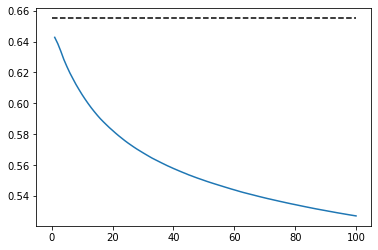

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

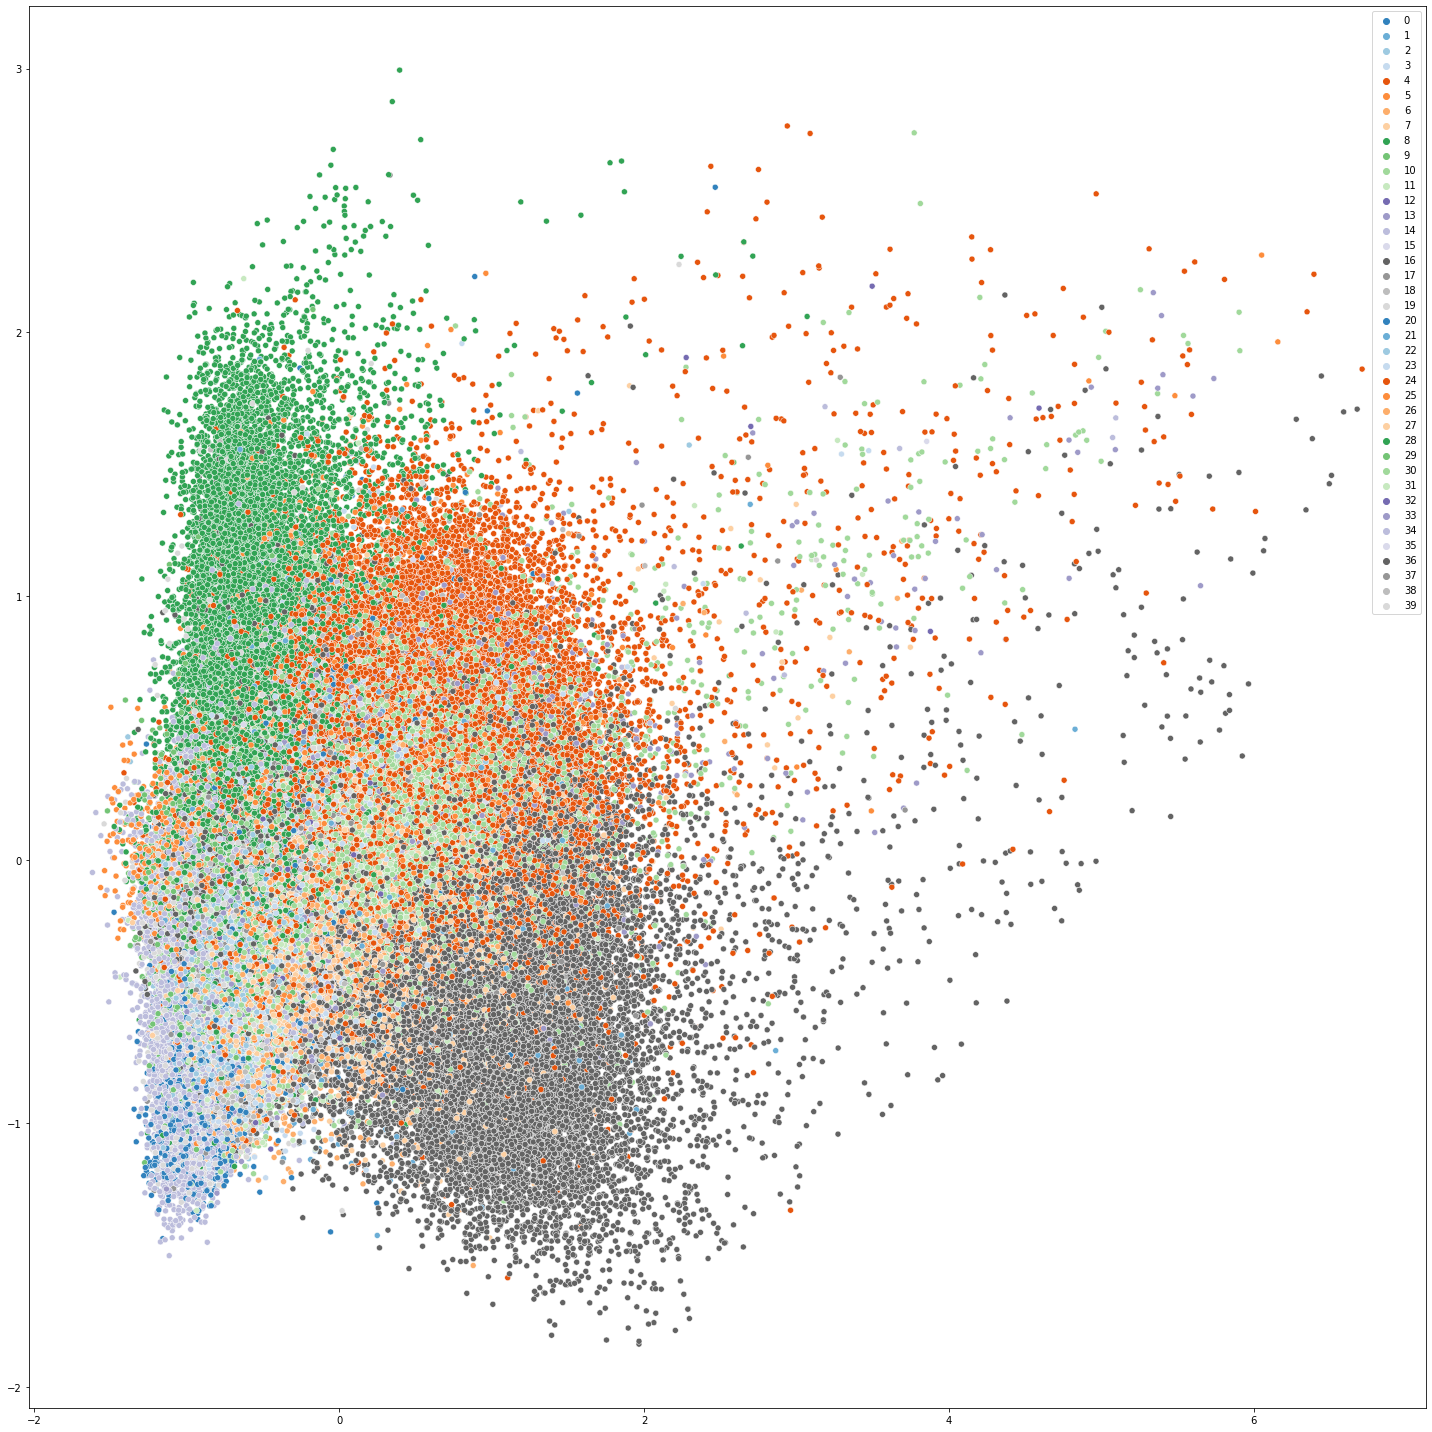

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

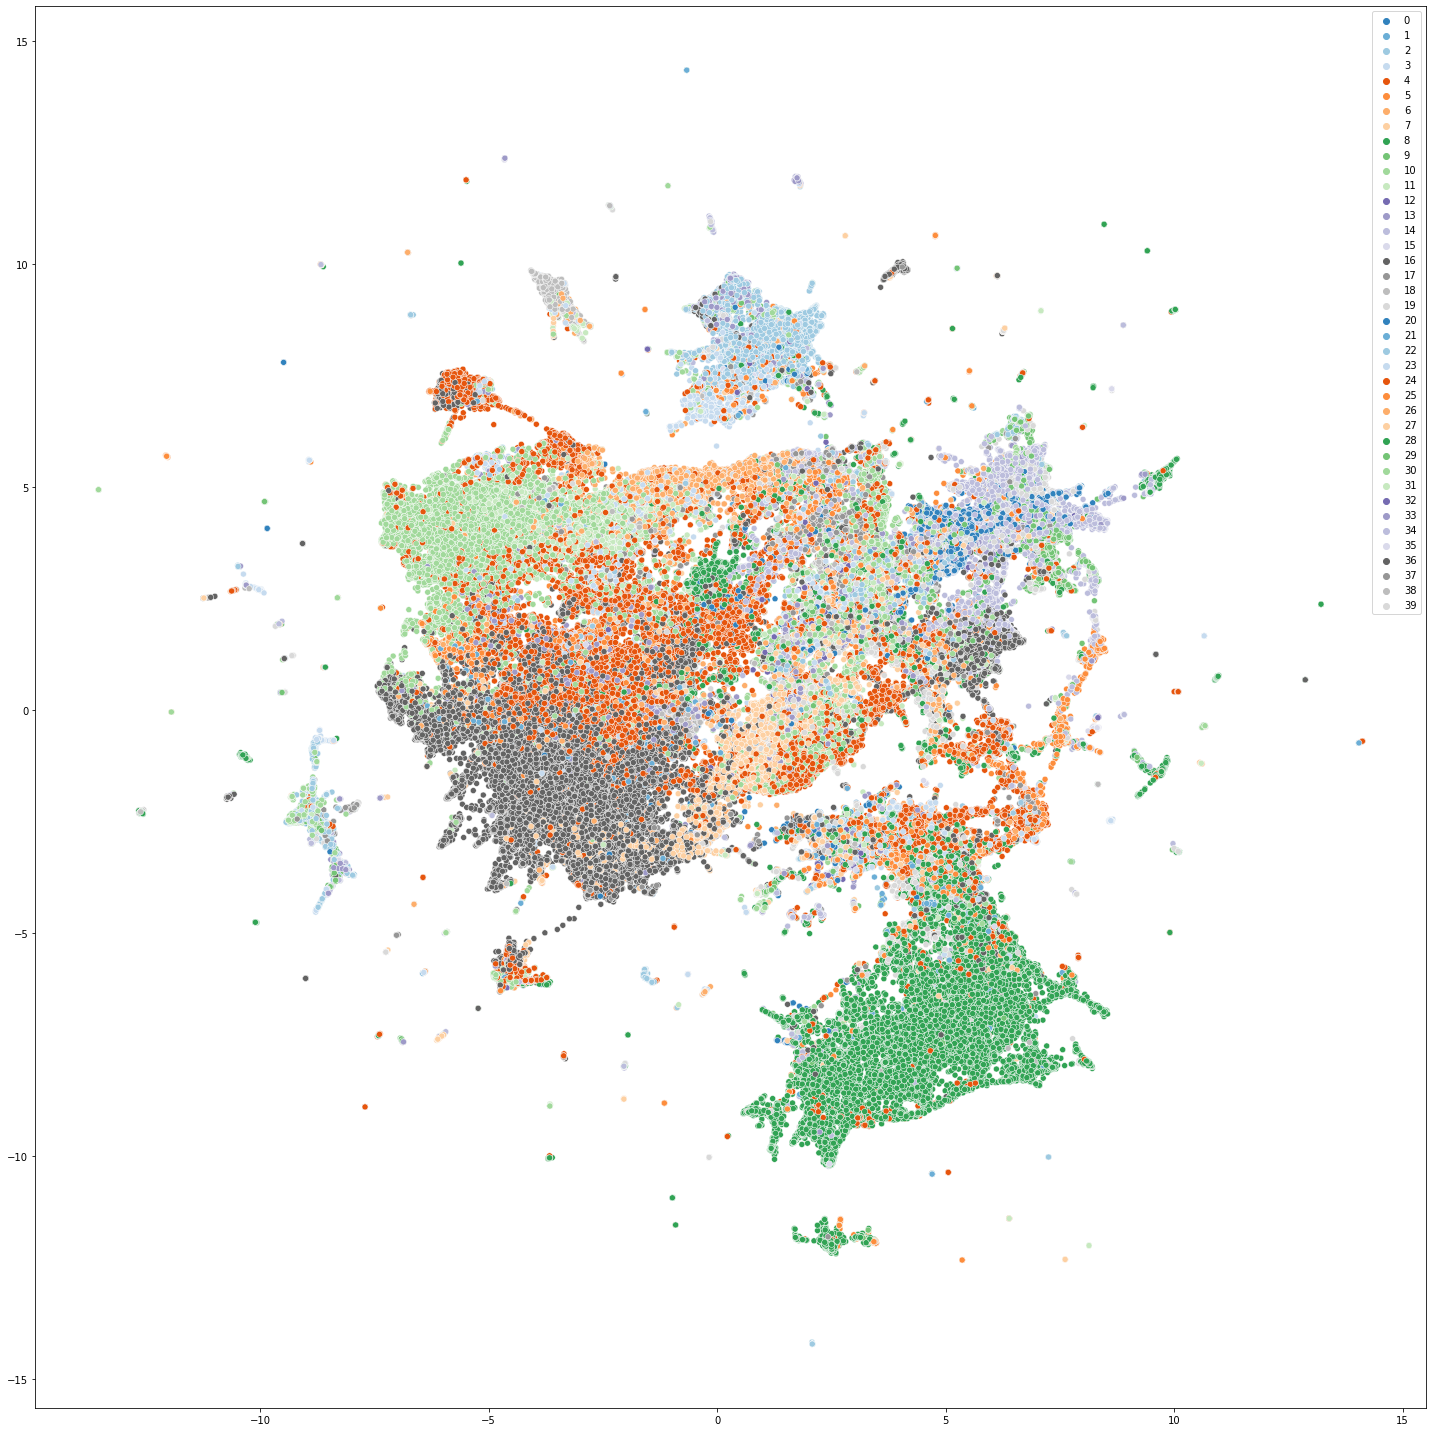

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

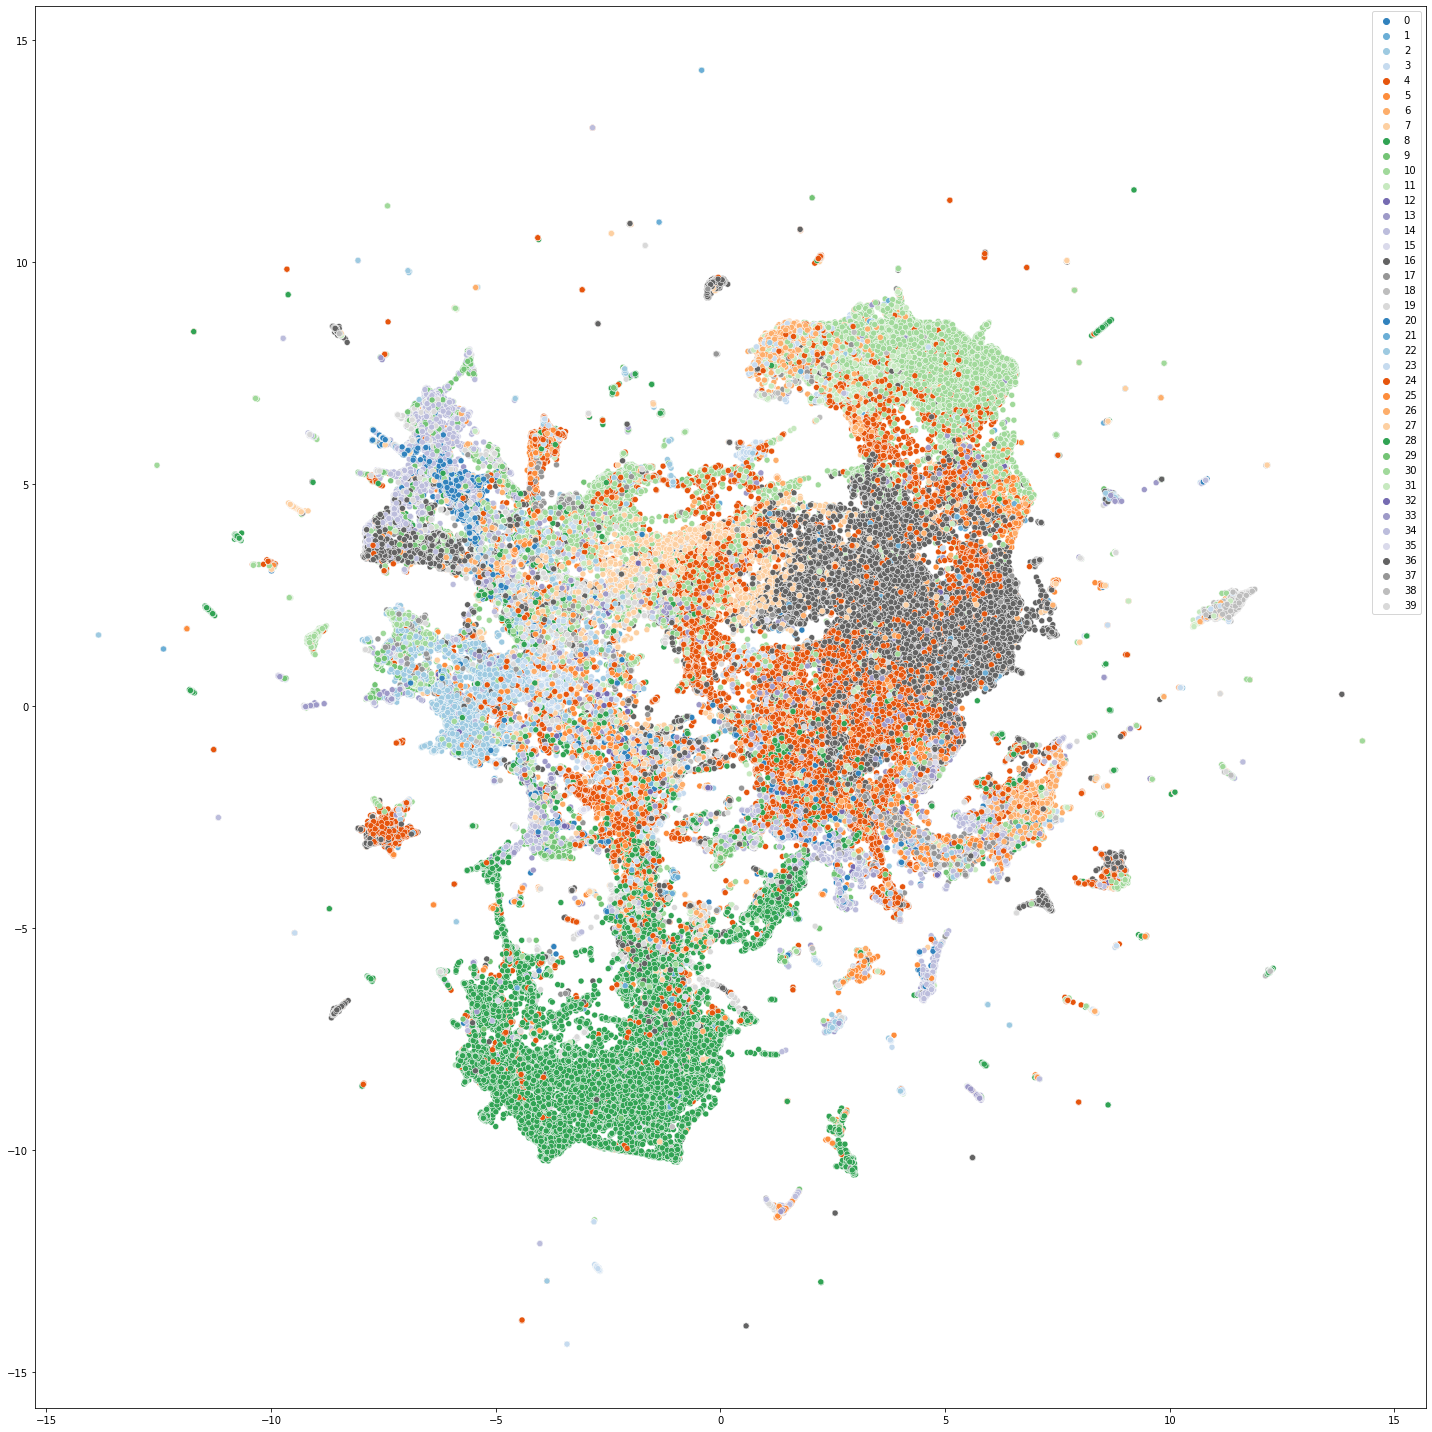

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()